In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

dict_losses = defaultdict(list)
with open("per_token_loss.txt", "r") as f:
    for line in f:
        if 'val' in line:
            continue
        losses = line.split('|')
        for loss in losses:
            i, val = loss.strip().split("=")
            i = int(i)
            val = abs(float(val))
            dict_losses[i].append(val)

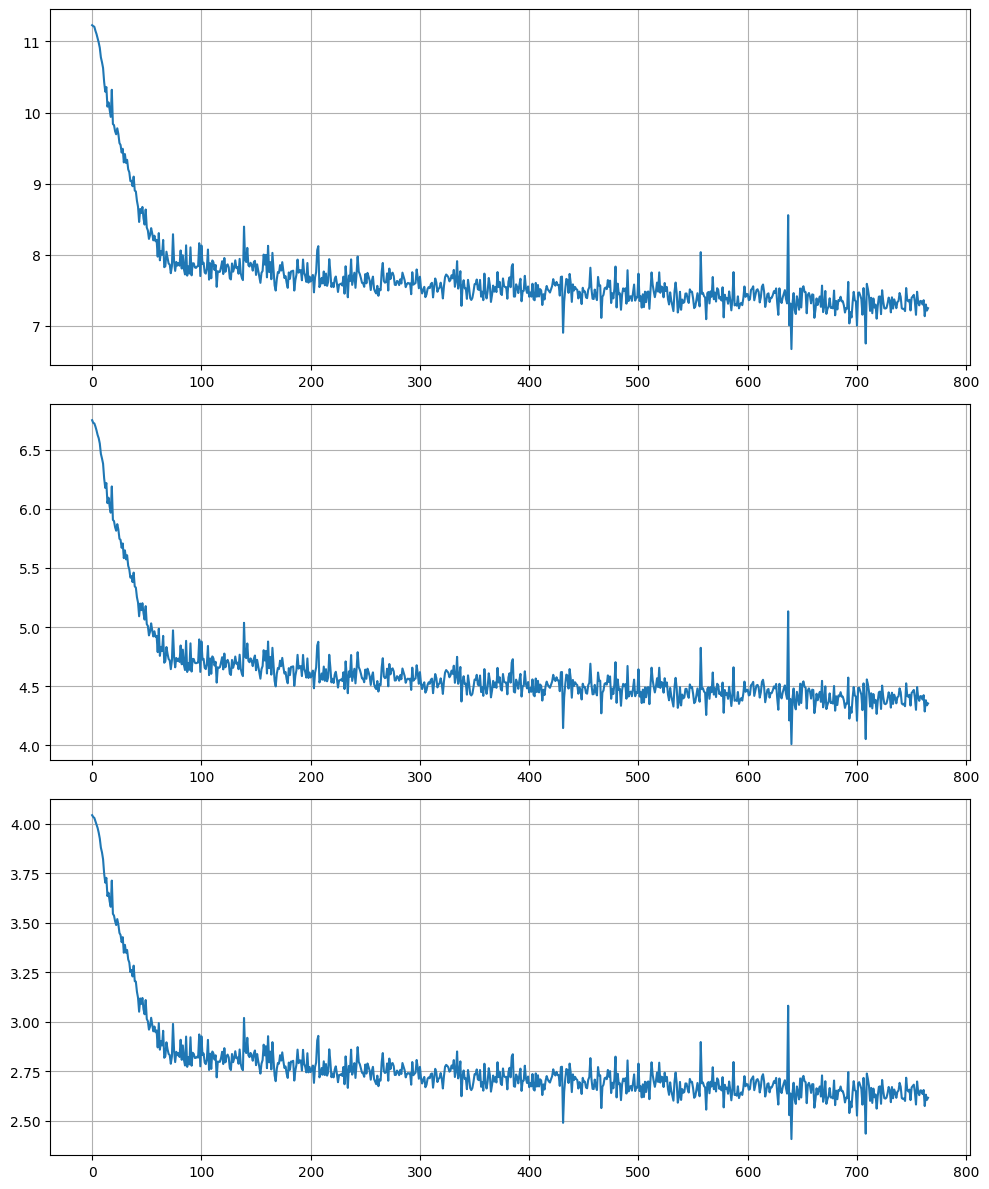

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Extract loss values from dictionary
for i in range(1, 4):
    axes[i-1].plot(range(len(dict_losses[i])), dict_losses[i])
    axes[i-1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()